Classifiaction d'informations RH 
Notre projet vise à analyser les données employé afin de classifier les profils en succeptible au turn-over.
L'objectif est de prédire si un employé est succeptible de démissionner.
C'est une tâche de ML supervisée aka Classification binaire.

In [667]:
# importer les bibliothèques
#%pip install --upgrade numpy pandas matplotlib seaborn scikit-learn nltk joblib tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
tqdm.pandas()
# Create transformers using those feature lists
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso


In [668]:
# acquisition/importation des données 
extraits_eval = pd.read_csv('../Datasets/extrait_eval.csv', sep=',')
extraits_sirh = pd.read_csv('../Datasets/extrait_sirh.csv', sep=',')
extrait_sondage = pd.read_csv('../Datasets/extrait_sondage.csv', sep=',')



# Inspection des données 

 --- inspection de la table extraits_eval --- 

In [669]:
# dimension  extraits_eval
extraits_eval.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

In [670]:
# informations 
extraits_eval.describe(include="object", exclude="number").T

,count,unique,top,freq
eval_number,1470,1470,E_1,1
heure_supplementaires,1470,2,Non,1054
augementation_salaire_precedente,1470,15,11 %,210


In [671]:
# informations 
extraits_eval.describe(exclude="object").T['mean']

satisfaction_employee_environnement          2.721769
note_evaluation_precedente                   2.729932
niveau_hierarchique_poste                    2.063946
satisfaction_employee_nature_travail         2.728571
satisfaction_employee_equipe                 2.712245
satisfaction_employee_equilibre_pro_perso    2.761224
note_evaluation_actuelle                     3.153741
Name: mean, dtype: float64

In [672]:
# recherche de données manquantes 
#print(extraits_eval.isnull().mean())
if (extraits_eval.isnull().mean().sum() == 0):
    print("Il n'y a pas de données manquantes dans le jeu de données extraits_eval")

Il n'y a pas de données manquantes dans le jeu de données extraits_eval


 --- inspection de la table sirh --- 

In [673]:
# informations 
extraits_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


In [674]:
# valeurs uniques des colonnes catégorielles
extraits_sirh.describe(include='object').T

    

,count,unique,top,freq
genre,1470,2,M,882
statut_marital,1470,3,Marié(e),673
departement,1470,3,Consulting,961
poste,1470,9,Cadre Commercial,326


In [675]:
# recherche des données manquantes
#print(extraits_sirh.isnull().mean())
if (extraits_sirh.isnull().mean().sum() == 0):
    print("Il n'y a pas de données manquantes dans le jeu de données extraits_sirh")

Il n'y a pas de données manquantes dans le jeu de données extraits_sirh


 --- inspection de la table extrait_sondage --- 

In [676]:
# informations 
extrait_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

In [677]:
# description des colonnes catégorielles
extrait_sondage.describe(include='object').T    

,count,unique,top,freq
a_quitte_l_entreprise,1470,2,Non,1233
domaine_etude,1470,6,Infra & Cloud,606
ayant_enfants,1470,1,Y,1470
frequence_deplacement,1470,3,Occasionnel,1043


In [678]:
# description des colonnes numériques
extrait_sondage.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
nombre_participation_pee,1470.0,0.793878,0.852077,0.0,0.00,1.0,1.00,3.0
nb_formations_suivies,1470.0,2.799320,1.289271,0.0,2.00,3.0,3.00,6.0
nombre_employee_sous_responsabilite,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
code_sondage,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
distance_domicile_travail,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
niveau_education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
annees_depuis_la_derniere_promotion,1470.0,2.187755,3.222430,0.0,0.00,1.0,3.00,15.0
annes_sous_responsable_actuel,1470.0,4.123129,3.568136,0.0,2.00,3.0,7.00,17.0


Il n'y a pas de données manquantes dans aucune des tables 

# ANALYSE EXPLORATOIRE  (EDA) 

In [679]:
# fonction pour EDA 
def EDA_de_table(df,df_name="",rotation=0):
    """
    Fonction pour l'analyse exploratoire des données (EDA) d'un DataFrame.
    Affiche les informations de base, les statistiques descriptives et les
    distributions des variables."""
    
    print(f"="*(30+len(df_name)+len("ANALYSE DE LA TABLE : ")))
    print(f" "*15,"ANALYSE DE LA TABLE :", df_name, " "*15)
    print("="*(30+len(df_name)+ len("ANALYSE DE LA TABLE : ")))

    for variable in df.columns:
        variable = df[variable]
        print("-"*10, "Analyse de la variable :", variable.name, "-"*10)
        print("Type de la variable :", variable.dtypes)
        print("Nombre de valeurs uniques :", variable.nunique())
        print("Valeurs uniques :", variable.unique())
        print("Statistiques descriptives :")
        print(variable.describe())
        print("Distribution des valeurs :")
        plt.figure(figsize=(10, 6))
        if (variable.dtypes == 'int64' and variable.nunique() > 15) :
            sns.displot(variable, bins=30)
            plt.title(f'Distribution de la variable {variable.name}')
            plt.show()
        else:
            variable = variable.astype('category')
            sns.countplot(x=variable, 
                        order=variable.value_counts().index, 
                        hue=variable,
                        stat='proportion'
                        )
            plt.xticks(rotation=rotation)
            plt.title(f'Distribution par ordre décroissant \n  \
                des proportions de la variable {variable.name}')
            plt.show()  
    print("\n")

                ANALYSE DE LA TABLE : extraits_eval                
---------- Analyse de la variable : satisfaction_employee_environnement ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [2 3 4 1]
Statistiques descriptives :
count    1470.000000
mean        2.721769
std         1.093082
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_environnement, dtype: float64
Distribution des valeurs :


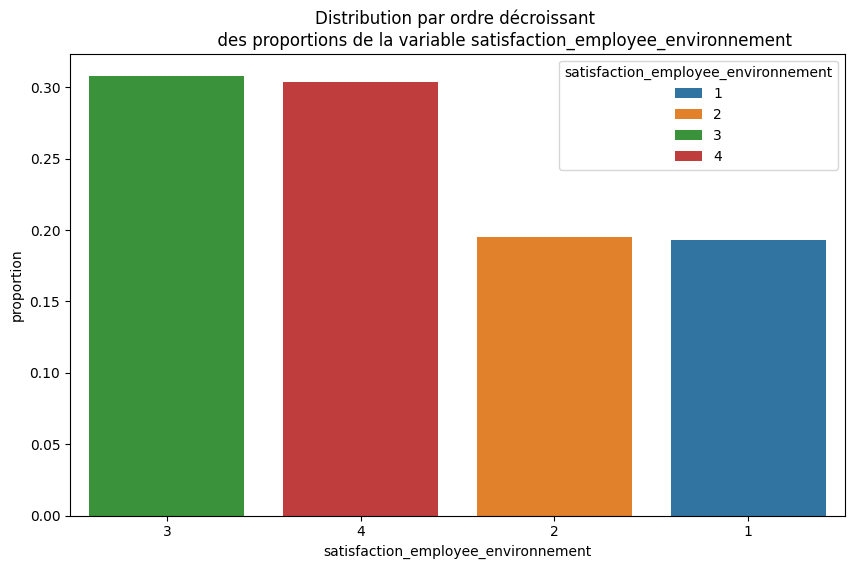

---------- Analyse de la variable : note_evaluation_precedente ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [3 2 4 1]
Statistiques descriptives :
count    1470.000000
mean        2.729932
std         0.711561
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_precedente, dtype: float64
Distribution des valeurs :


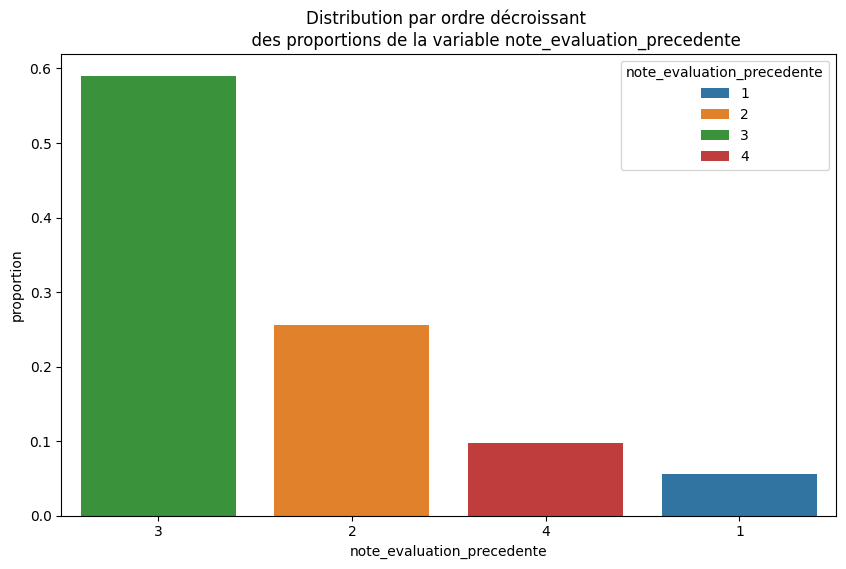

---------- Analyse de la variable : niveau_hierarchique_poste ----------
Type de la variable : int64
Nombre de valeurs uniques : 5
Valeurs uniques : [2 1 3 4 5]
Statistiques descriptives :
count    1470.000000
mean        2.063946
std         1.106940
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: niveau_hierarchique_poste, dtype: float64
Distribution des valeurs :


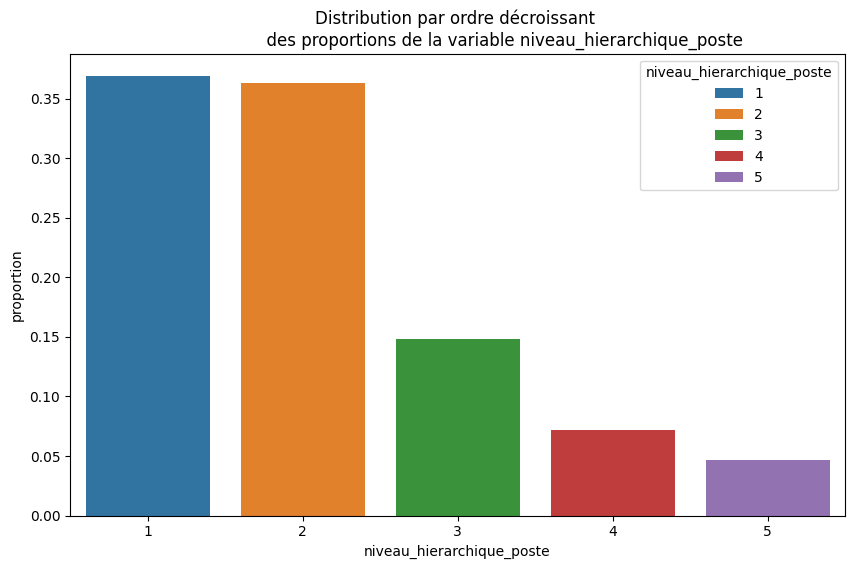

---------- Analyse de la variable : satisfaction_employee_nature_travail ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [4 2 3 1]
Statistiques descriptives :
count    1470.000000
mean        2.728571
std         1.102846
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_nature_travail, dtype: float64
Distribution des valeurs :


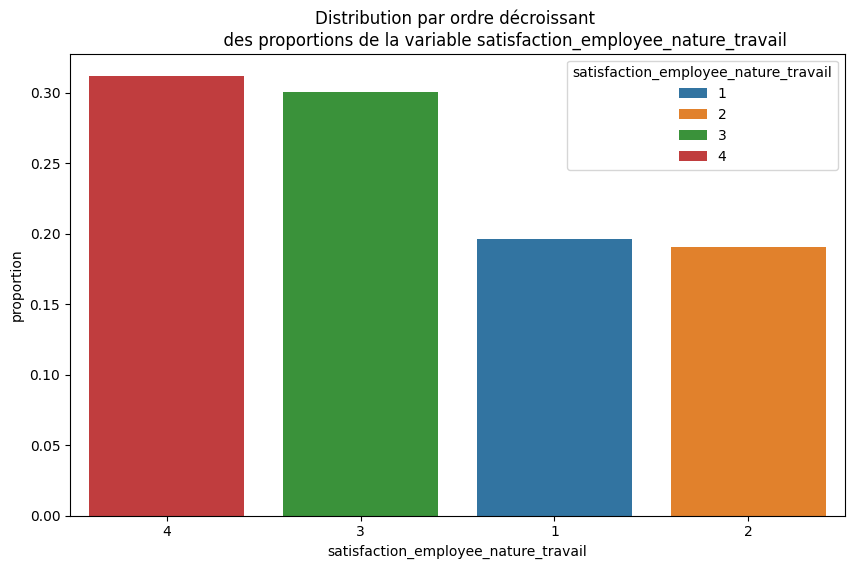

---------- Analyse de la variable : satisfaction_employee_equipe ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [1 4 2 3]
Statistiques descriptives :
count    1470.000000
mean        2.712245
std         1.081209
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_equipe, dtype: float64
Distribution des valeurs :


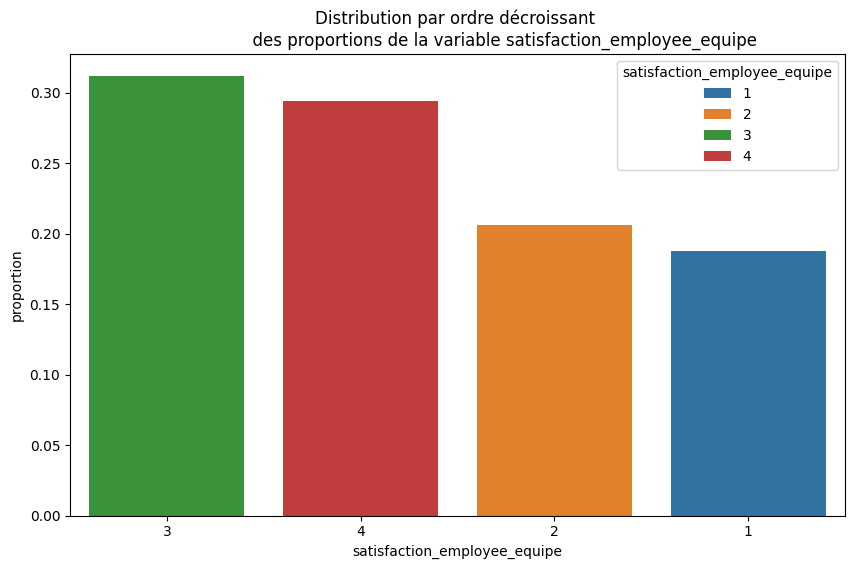

---------- Analyse de la variable : satisfaction_employee_equilibre_pro_perso ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [1 3 2 4]
Statistiques descriptives :
count    1470.000000
mean        2.761224
std         0.706476
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: satisfaction_employee_equilibre_pro_perso, dtype: float64
Distribution des valeurs :


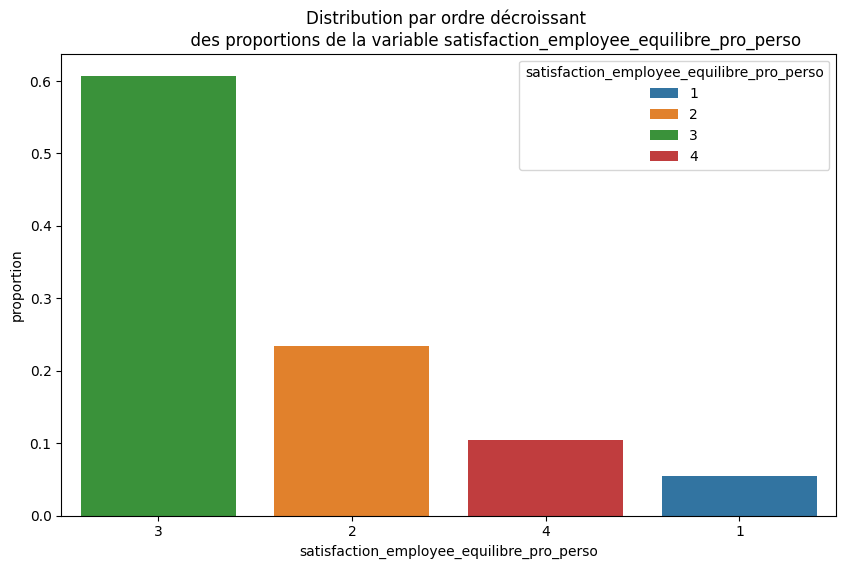

---------- Analyse de la variable : eval_number ----------
Type de la variable : object
Nombre de valeurs uniques : 1470
Valeurs uniques : ['E_1' 'E_2' 'E_4' ... 'E_2064' 'E_2065' 'E_2068']
Statistiques descriptives :
count     1470
unique    1470
top        E_1
freq         1
Name: eval_number, dtype: object
Distribution des valeurs :


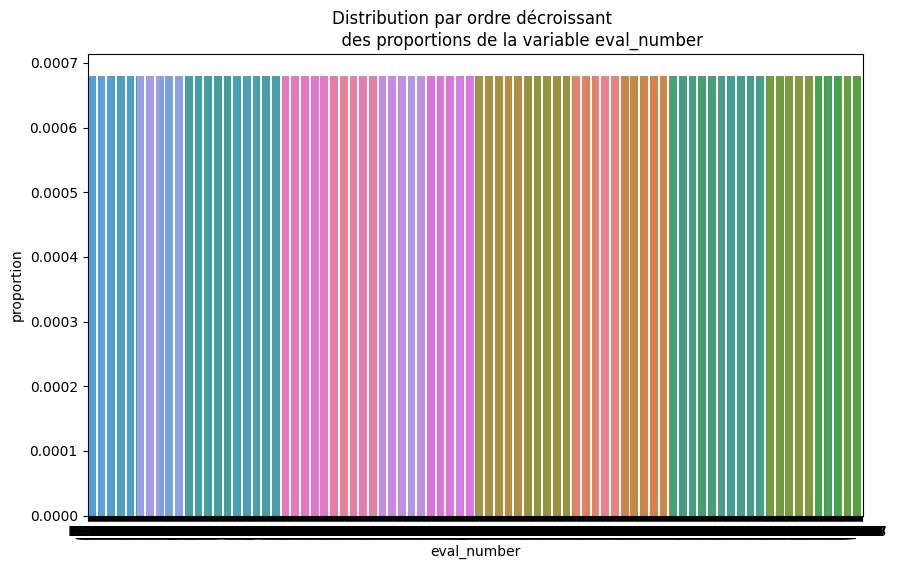

---------- Analyse de la variable : note_evaluation_actuelle ----------
Type de la variable : int64
Nombre de valeurs uniques : 2
Valeurs uniques : [3 4]
Statistiques descriptives :
count    1470.000000
mean        3.153741
std         0.360824
min         3.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_actuelle, dtype: float64
Distribution des valeurs :


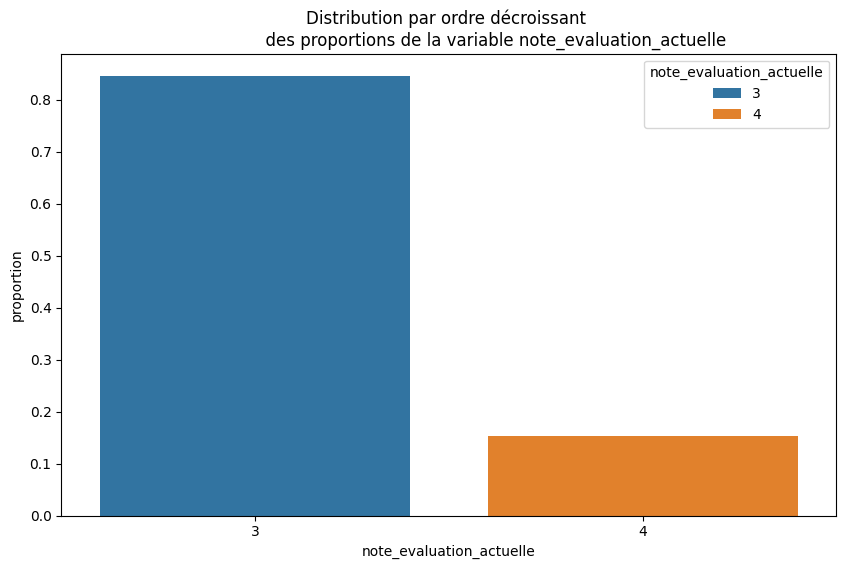

---------- Analyse de la variable : heure_supplementaires ----------
Type de la variable : object
Nombre de valeurs uniques : 2
Valeurs uniques : ['Oui' 'Non']
Statistiques descriptives :
count     1470
unique       2
top        Non
freq      1054
Name: heure_supplementaires, dtype: object
Distribution des valeurs :


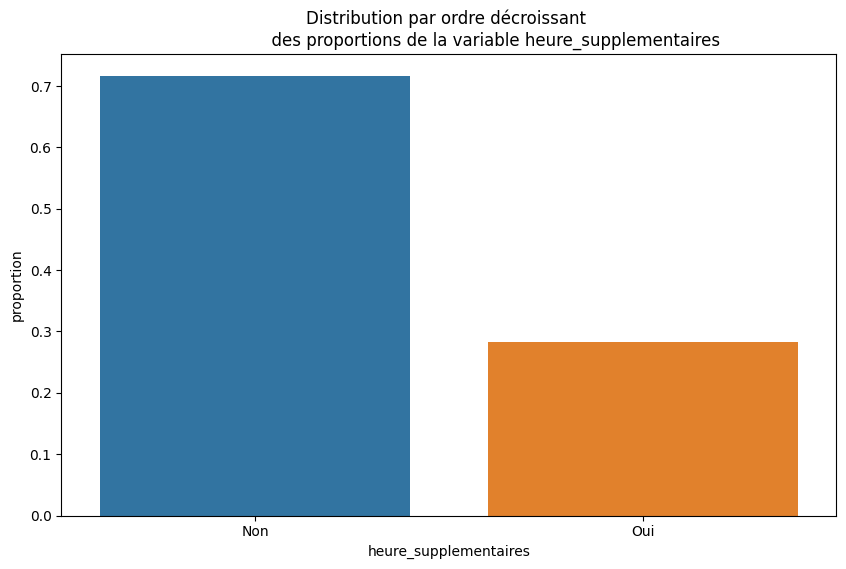

---------- Analyse de la variable : augementation_salaire_precedente ----------
Type de la variable : object
Nombre de valeurs uniques : 15
Valeurs uniques : ['11 %' '23 %' '15 %' '12 %' '13 %' '20 %' '22 %' '21 %' '17 %' '14 %'
 '16 %' '18 %' '19 %' '24 %' '25 %']
Statistiques descriptives :
count     1470
unique      15
top       11 %
freq       210
Name: augementation_salaire_precedente, dtype: object
Distribution des valeurs :


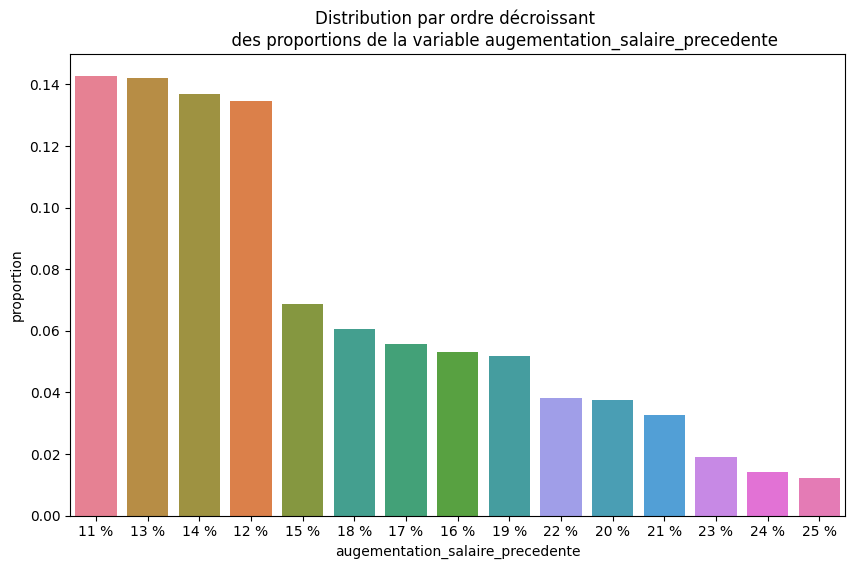

In [680]:
# EDA table extraits_eval   
EDA_de_table(df=extraits_eval,df_name="extraits_eval")

In [681]:
# description extraits_sirh
extraits_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


                ANALYSE DE LA TABLE : extraits_sirh                
---------- Analyse de la variable : id_employee ----------
Type de la variable : int64
Nombre de valeurs uniques : 1470
Valeurs uniques : [   1    2    4 ... 2064 2065 2068]
Statistiques descriptives :
count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: id_employee, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

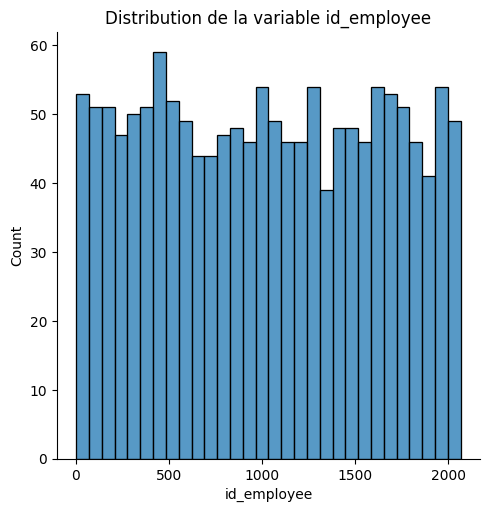

---------- Analyse de la variable : age ----------
Type de la variable : int64
Nombre de valeurs uniques : 43
Valeurs uniques : [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
Statistiques descriptives :
count    1470.000000
mean       36.923810
std         9.135373
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: age, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

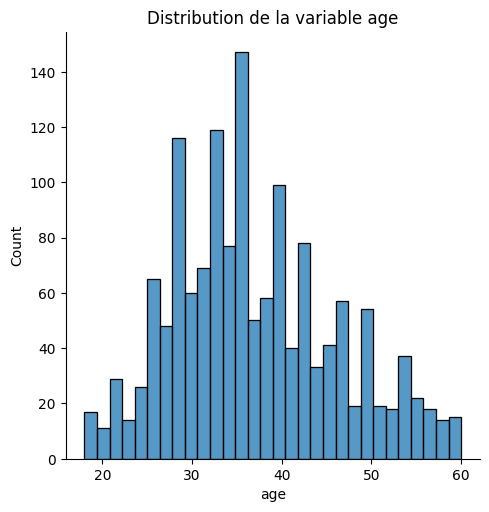

---------- Analyse de la variable : genre ----------
Type de la variable : object
Nombre de valeurs uniques : 2
Valeurs uniques : ['F' 'M']
Statistiques descriptives :
count     1470
unique       2
top          M
freq       882
Name: genre, dtype: object
Distribution des valeurs :


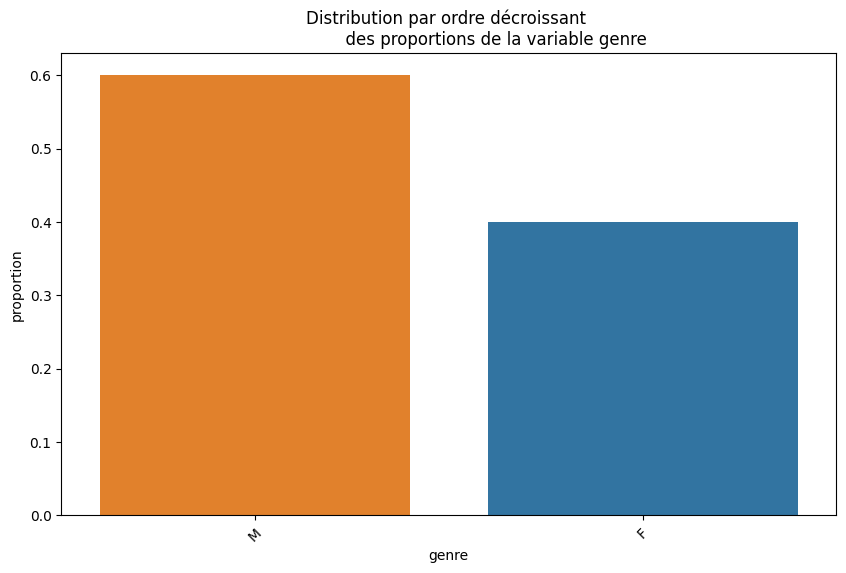

---------- Analyse de la variable : revenu_mensuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 1349
Valeurs uniques : [5993 5130 2090 ... 9991 5390 4404]
Statistiques descriptives :
count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: revenu_mensuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

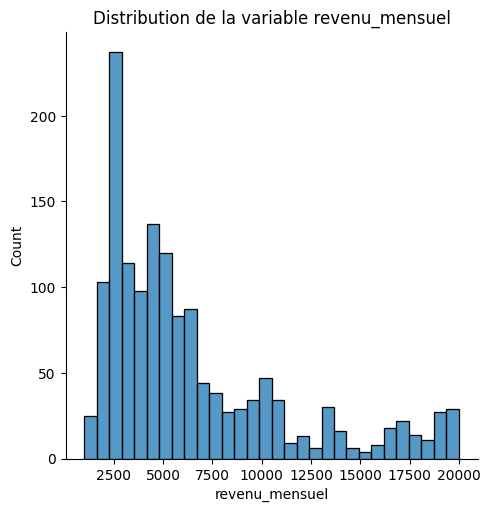

---------- Analyse de la variable : statut_marital ----------
Type de la variable : object
Nombre de valeurs uniques : 3
Valeurs uniques : ['Célibataire' 'Marié(e)' 'Divorcé(e)']
Statistiques descriptives :
count         1470
unique           3
top       Marié(e)
freq           673
Name: statut_marital, dtype: object
Distribution des valeurs :


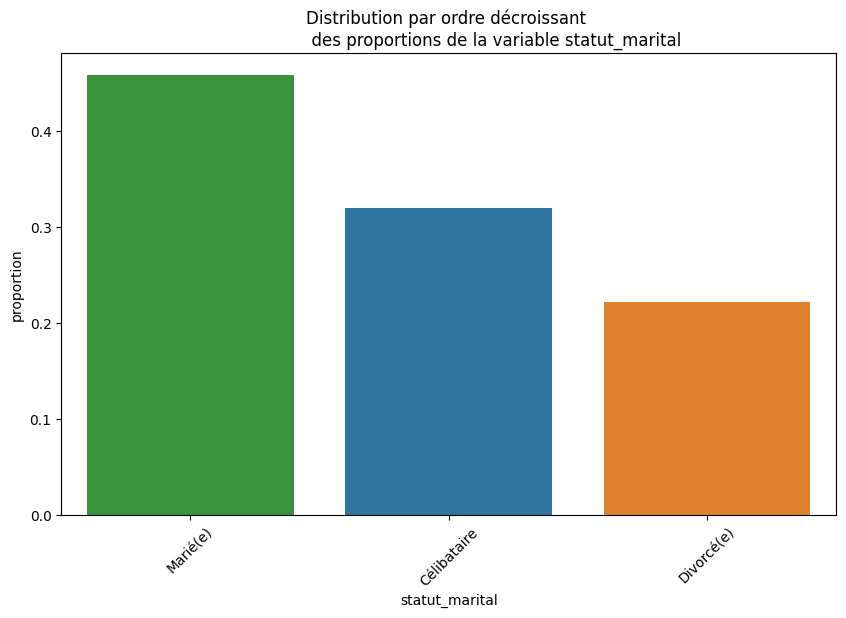

---------- Analyse de la variable : departement ----------
Type de la variable : object
Nombre de valeurs uniques : 3
Valeurs uniques : ['Commercial' 'Consulting' 'Ressources Humaines']
Statistiques descriptives :
count           1470
unique             3
top       Consulting
freq             961
Name: departement, dtype: object
Distribution des valeurs :


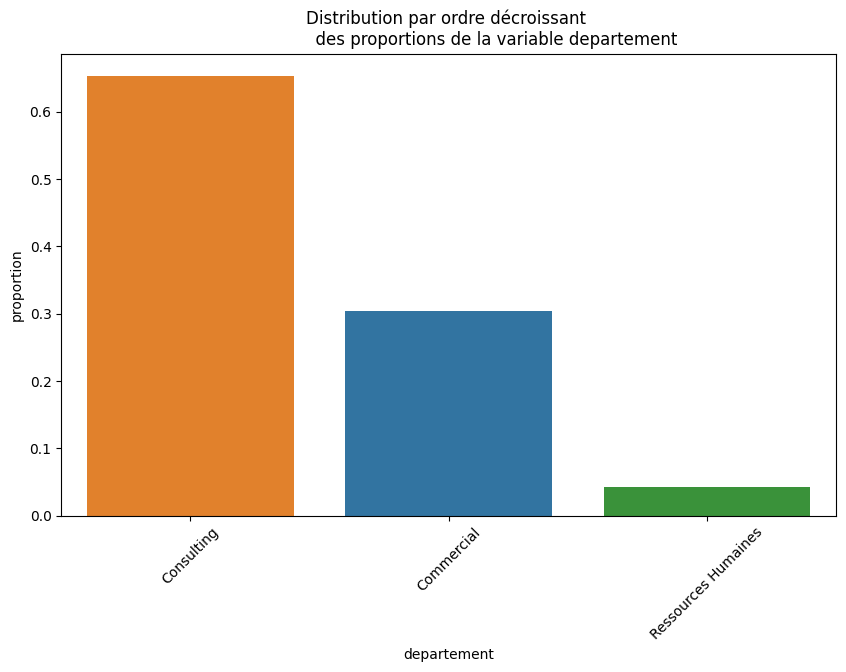

---------- Analyse de la variable : poste ----------
Type de la variable : object
Nombre de valeurs uniques : 9
Valeurs uniques : ['Cadre Commercial' 'Assistant de Direction' 'Consultant' 'Tech Lead'
 'Manager' 'Senior Manager' 'Représentant Commercial'
 'Directeur Technique' 'Ressources Humaines']
Statistiques descriptives :
count                 1470
unique                   9
top       Cadre Commercial
freq                   326
Name: poste, dtype: object
Distribution des valeurs :


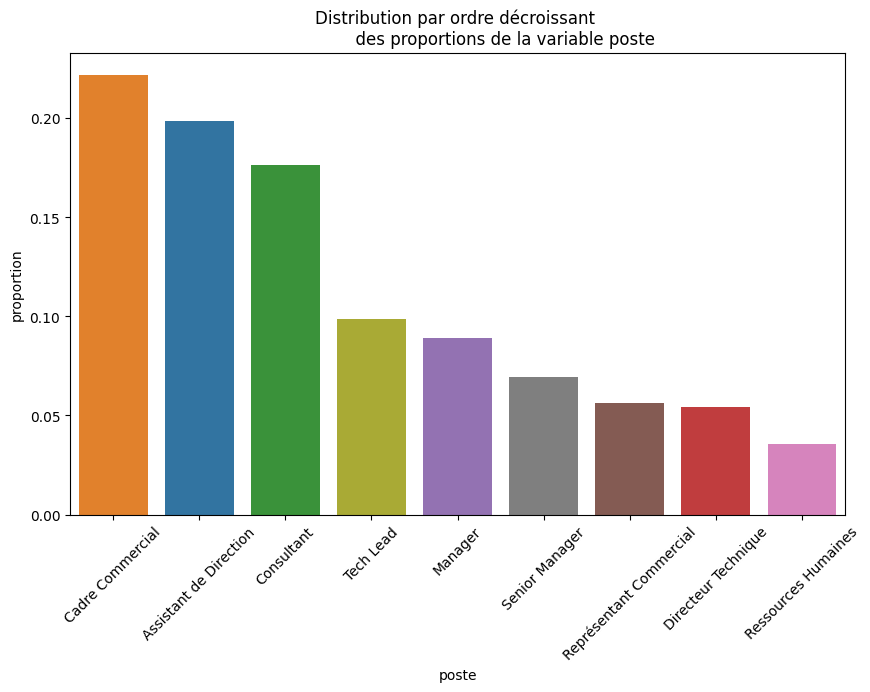

---------- Analyse de la variable : nombre_experiences_precedentes ----------
Type de la variable : int64
Nombre de valeurs uniques : 10
Valeurs uniques : [8 1 6 9 0 4 5 2 7 3]
Statistiques descriptives :
count    1470.000000
mean        2.693197
std         2.498009
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: nombre_experiences_precedentes, dtype: float64
Distribution des valeurs :


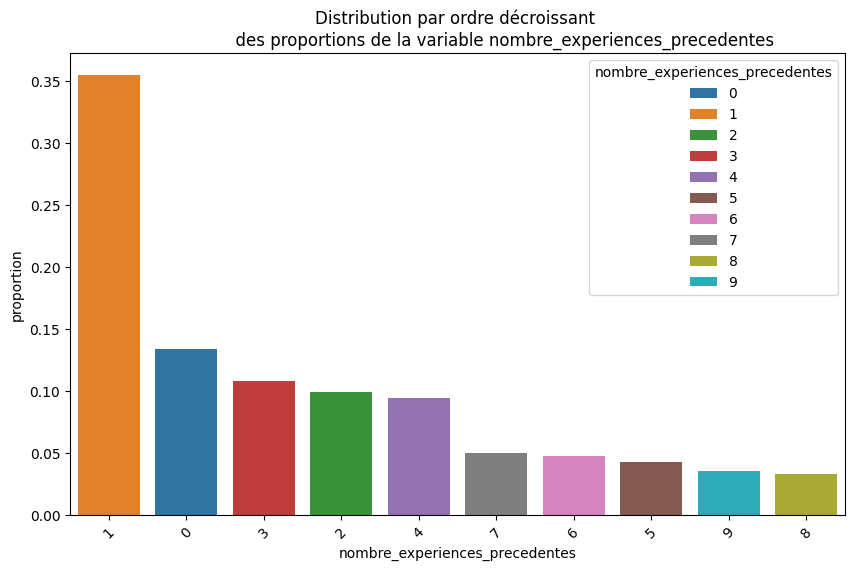

---------- Analyse de la variable : nombre_heures_travailless ----------
Type de la variable : int64
Nombre de valeurs uniques : 1
Valeurs uniques : [80]
Statistiques descriptives :
count    1470.0
mean       80.0
std         0.0
min        80.0
25%        80.0
50%        80.0
75%        80.0
max        80.0
Name: nombre_heures_travailless, dtype: float64
Distribution des valeurs :


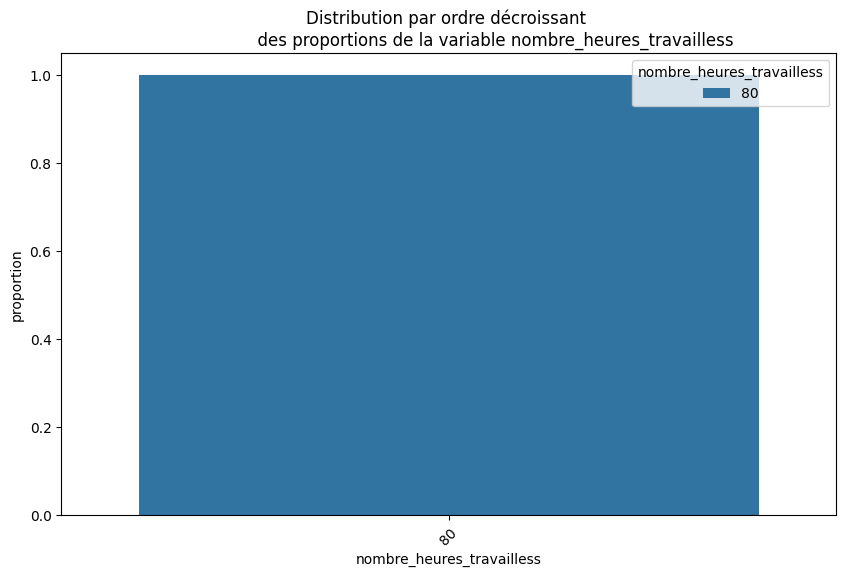

---------- Analyse de la variable : annee_experience_totale ----------
Type de la variable : int64
Nombre de valeurs uniques : 40
Valeurs uniques : [ 8 10  7  6 12  1 17  5  3 31 13  0 26 24 22  9 19  2 23 14 15  4 29 28
 21 25 20 11 16 37 38 30 40 18 36 34 32 33 35 27]
Statistiques descriptives :
count    1470.000000
mean       11.279592
std         7.780782
min         0.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        40.000000
Name: annee_experience_totale, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

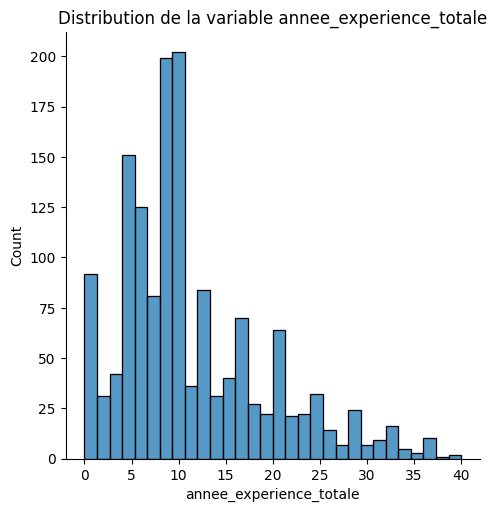

---------- Analyse de la variable : annees_dans_l_entreprise ----------
Type de la variable : int64
Nombre de valeurs uniques : 37
Valeurs uniques : [ 6 10  0  8  2  7  1  9  5  4 25  3 12 14 22 15 27 21 17 11 13 37 16 20
 40 24 33 19 36 18 29 31 32 34 26 30 23]
Statistiques descriptives :
count    1470.000000
mean        7.008163
std         6.126525
min         0.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        40.000000
Name: annees_dans_l_entreprise, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

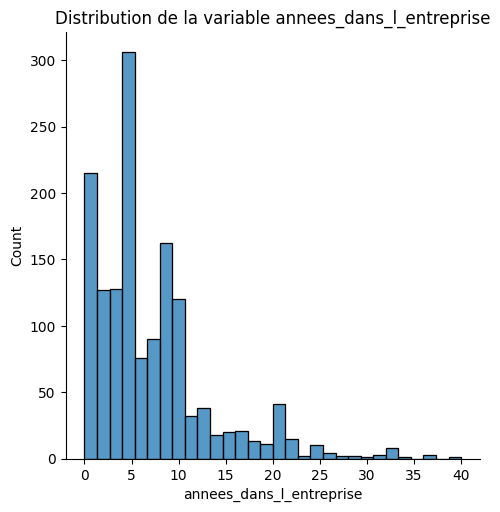

---------- Analyse de la variable : annees_dans_le_poste_actuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 19
Valeurs uniques : [ 4  7  0  2  5  9  8  3  6 13  1 15 14 16 11 10 12 18 17]
Statistiques descriptives :
count    1470.000000
mean        4.229252
std         3.623137
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        18.000000
Name: annees_dans_le_poste_actuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

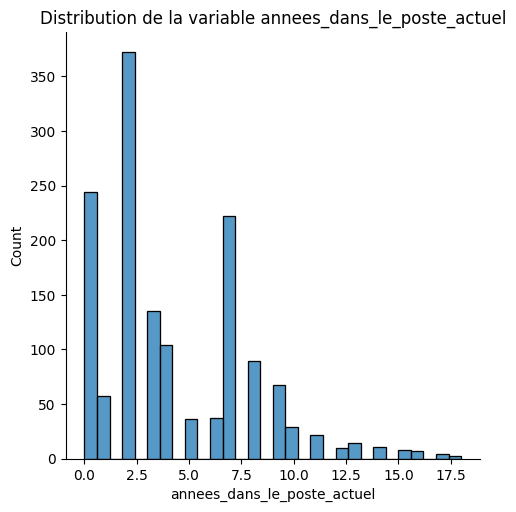

In [682]:
# EDA des variables de la table extraits_sirh
EDA_de_table(df=extraits_sirh,df_name="extraits_sirh", rotation=45)

In [683]:
# analyse descriptive extrait_sondage
extrait_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

                ANALYSE DE LA TABLE : extrait_sondage                
---------- Analyse de la variable : a_quitte_l_entreprise ----------
Type de la variable : object
Nombre de valeurs uniques : 2
Valeurs uniques : ['Oui' 'Non']
Statistiques descriptives :
count     1470
unique       2
top        Non
freq      1233
Name: a_quitte_l_entreprise, dtype: object
Distribution des valeurs :


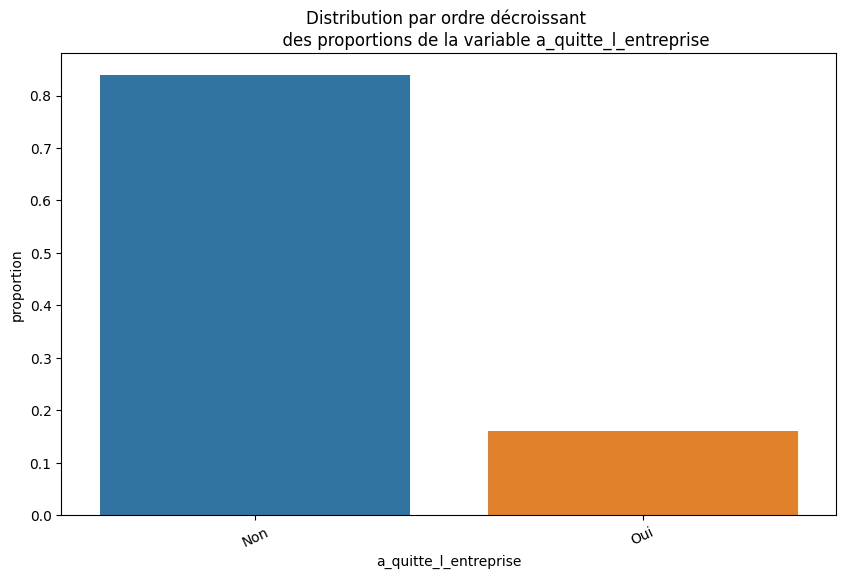

---------- Analyse de la variable : nombre_participation_pee ----------
Type de la variable : int64
Nombre de valeurs uniques : 4
Valeurs uniques : [0 1 3 2]
Statistiques descriptives :
count    1470.000000
mean        0.793878
std         0.852077
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: nombre_participation_pee, dtype: float64
Distribution des valeurs :


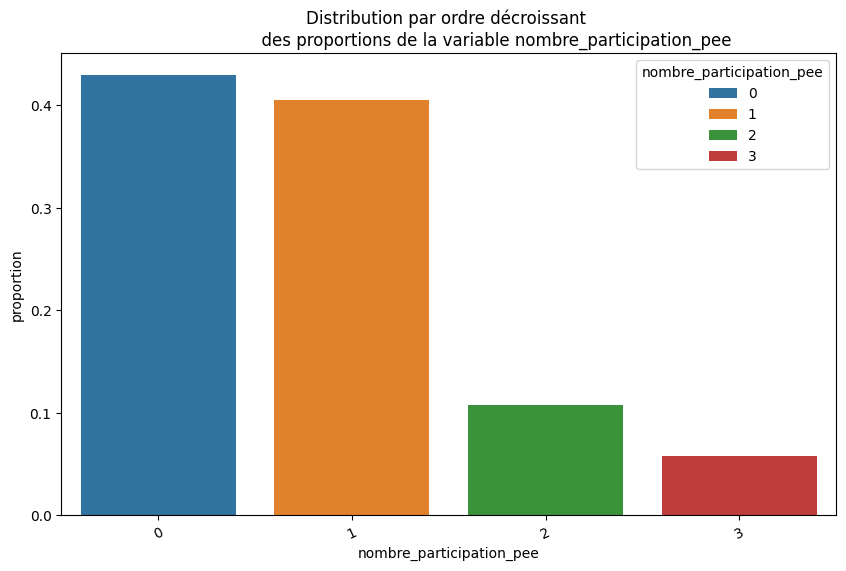

---------- Analyse de la variable : nb_formations_suivies ----------
Type de la variable : int64
Nombre de valeurs uniques : 7
Valeurs uniques : [0 3 2 5 1 4 6]
Statistiques descriptives :
count    1470.000000
mean        2.799320
std         1.289271
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: nb_formations_suivies, dtype: float64
Distribution des valeurs :


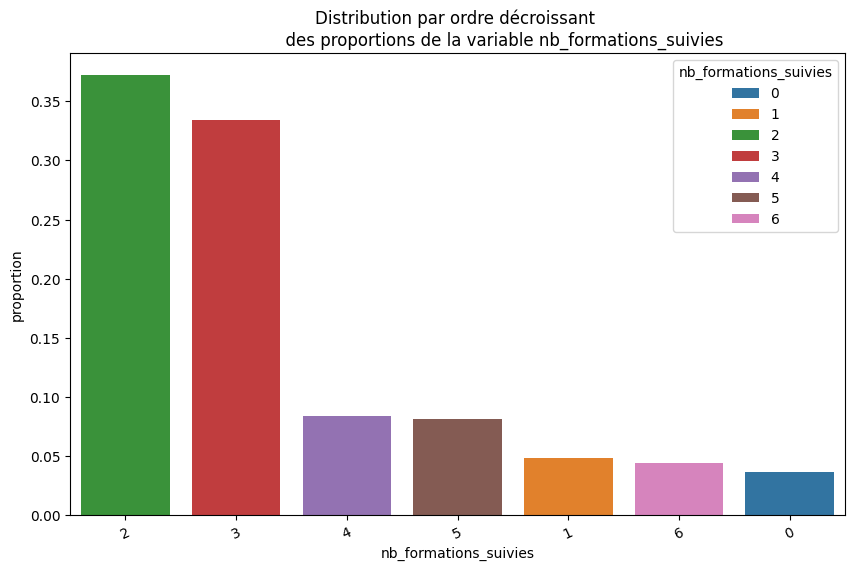

---------- Analyse de la variable : nombre_employee_sous_responsabilite ----------
Type de la variable : int64
Nombre de valeurs uniques : 1
Valeurs uniques : [1]
Statistiques descriptives :
count    1470.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: nombre_employee_sous_responsabilite, dtype: float64
Distribution des valeurs :


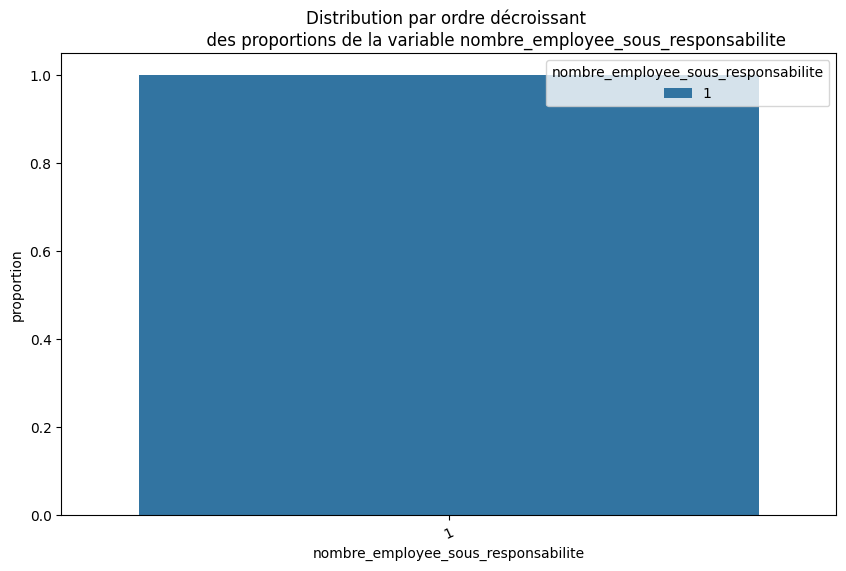

---------- Analyse de la variable : code_sondage ----------
Type de la variable : int64
Nombre de valeurs uniques : 1470
Valeurs uniques : [   1    2    4 ... 2064 2065 2068]
Statistiques descriptives :
count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: code_sondage, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

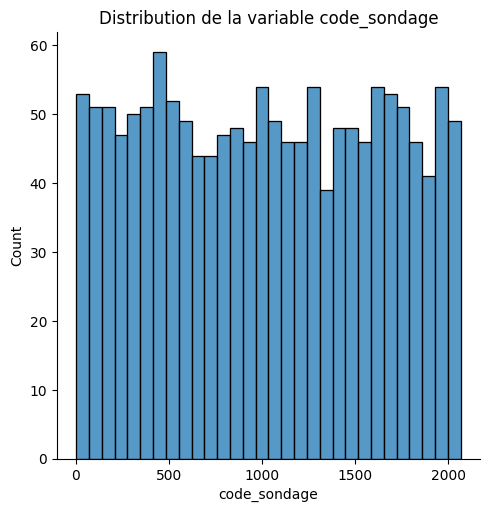

---------- Analyse de la variable : distance_domicile_travail ----------
Type de la variable : int64
Nombre de valeurs uniques : 29
Valeurs uniques : [ 1  8  2  3 24 23 27 16 15 26 19 21  5 11  9  7  6 10  4 25 12 18 29 22
 14 20 28 17 13]
Statistiques descriptives :
count    1470.000000
mean        9.192517
std         8.106864
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: distance_domicile_travail, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

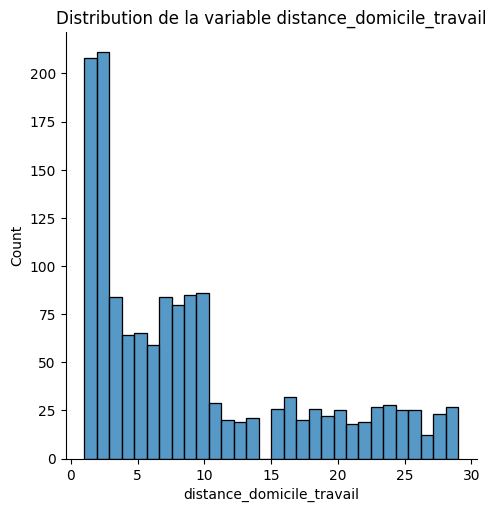

---------- Analyse de la variable : niveau_education ----------
Type de la variable : int64
Nombre de valeurs uniques : 5
Valeurs uniques : [2 1 4 3 5]
Statistiques descriptives :
count    1470.000000
mean        2.912925
std         1.024165
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: niveau_education, dtype: float64
Distribution des valeurs :


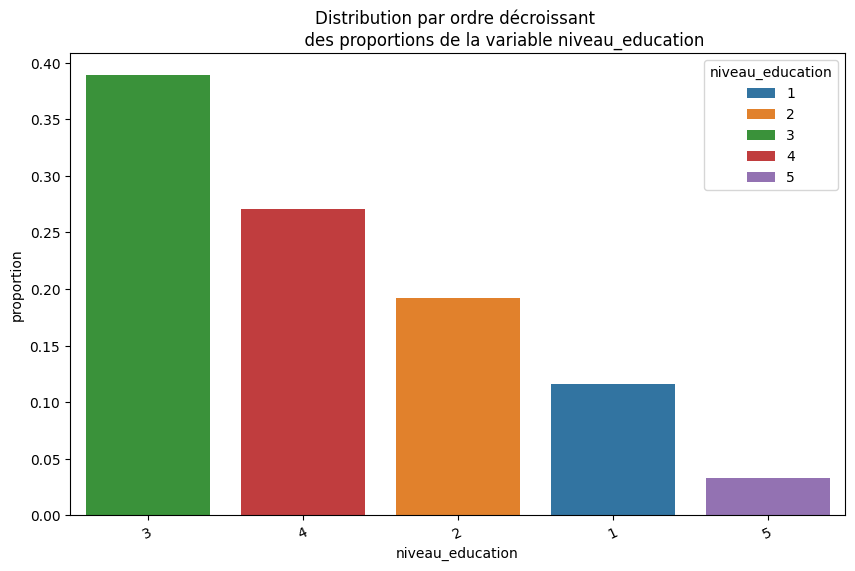

---------- Analyse de la variable : domaine_etude ----------
Type de la variable : object
Nombre de valeurs uniques : 6
Valeurs uniques : ['Infra & Cloud' 'Autre' 'Transformation Digitale' 'Marketing'
 'Entrepreunariat' 'Ressources Humaines']
Statistiques descriptives :
count              1470
unique                6
top       Infra & Cloud
freq                606
Name: domaine_etude, dtype: object
Distribution des valeurs :


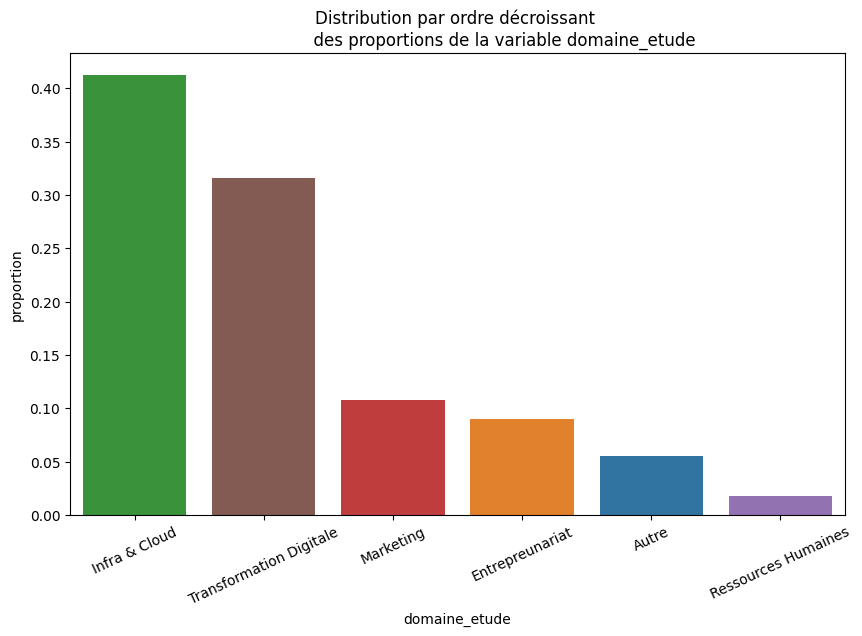

---------- Analyse de la variable : ayant_enfants ----------
Type de la variable : object
Nombre de valeurs uniques : 1
Valeurs uniques : ['Y']
Statistiques descriptives :
count     1470
unique       1
top          Y
freq      1470
Name: ayant_enfants, dtype: object
Distribution des valeurs :


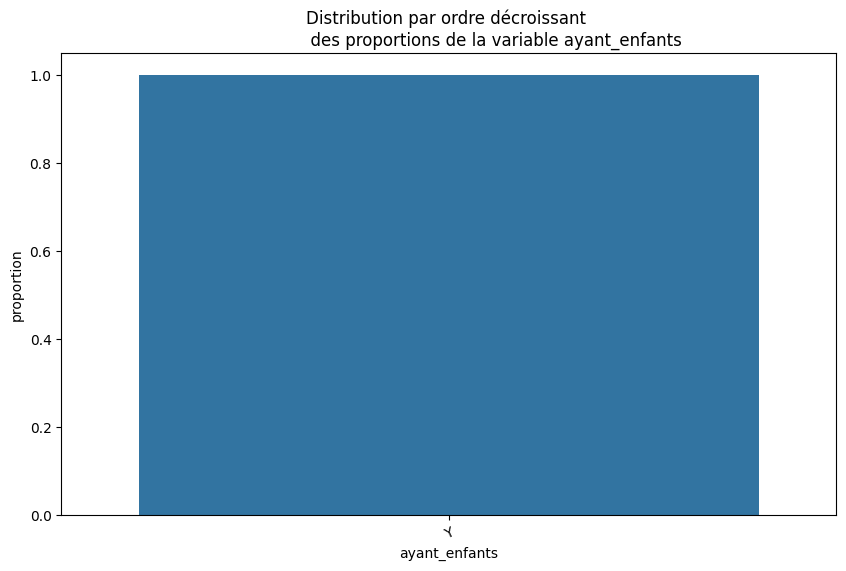

---------- Analyse de la variable : frequence_deplacement ----------
Type de la variable : object
Nombre de valeurs uniques : 3
Valeurs uniques : ['Occasionnel' 'Frequent' 'Aucun']
Statistiques descriptives :
count            1470
unique              3
top       Occasionnel
freq             1043
Name: frequence_deplacement, dtype: object
Distribution des valeurs :


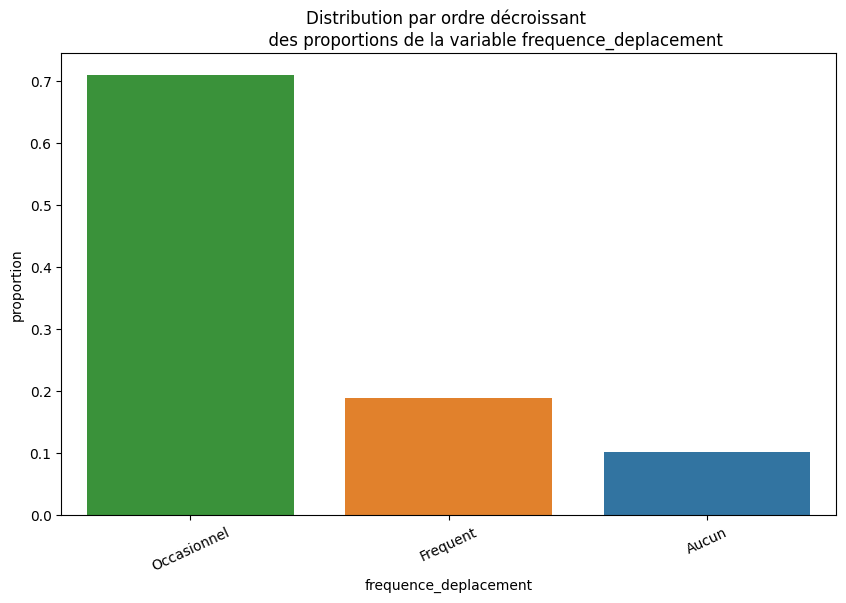

---------- Analyse de la variable : annees_depuis_la_derniere_promotion ----------
Type de la variable : int64
Nombre de valeurs uniques : 16
Valeurs uniques : [ 0  1  3  2  7  4  8  6  5 15  9 13 12 10 11 14]
Statistiques descriptives :
count    1470.000000
mean        2.187755
std         3.222430
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: annees_depuis_la_derniere_promotion, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

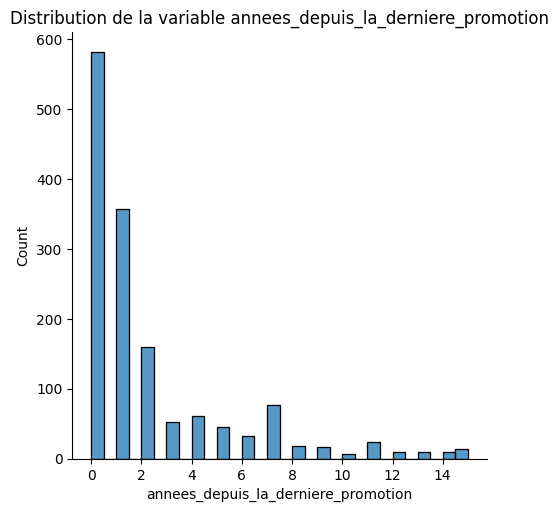

---------- Analyse de la variable : annes_sous_responsable_actuel ----------
Type de la variable : int64
Nombre de valeurs uniques : 18
Valeurs uniques : [ 5  7  0  2  6  8  3 11 17  1  4 12  9 10 15 13 16 14]
Statistiques descriptives :
count    1470.000000
mean        4.123129
std         3.568136
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        17.000000
Name: annes_sous_responsable_actuel, dtype: float64
Distribution des valeurs :


<Figure size 1000x600 with 0 Axes>

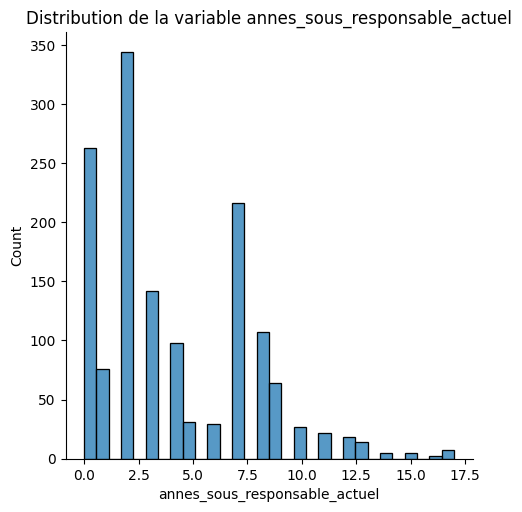

In [684]:
# EDA des variables de la table extrait_sondage
EDA_de_table(df=extrait_sondage,df_name="extrait_sondage", rotation=25)  

In [685]:
# nombre de valeurs uniques dans la colonne 'eval_number'
if (extraits_eval['eval_number'].nunique() ==  extraits_eval.shape[0]):
    print("La colonne 'eval_number' est une clé primaire unique pour la table extraits_eval")

La colonne 'eval_number' est une clé primaire unique pour la table extraits_eval


In [686]:
# valeurs unique dans la variable nombre_heures_travaillees
extraits_sirh['nombre_heures_travailless'].unique()
print("pas de variabilité")

pas de variabilité


In [687]:
# valeurs unique dans la variable statut_employe
extrait_sondage['ayant_enfants'].value_counts()
print("pas de variabilité")

pas de variabilité


Certaines variables ne présentent pas de variabilité , éliminons les après avoir effectué des jointures de tables.

In [688]:
extraits_eval['eval_number'] .head()

0    E_1
1    E_2
2    E_4
3    E_5
4    E_7
Name: eval_number, dtype: object

In [689]:
# extraction de la partie numérique de la colonne 'eval_number'
extraits_eval['eval_number'] = extraits_eval['eval_number'].apply(lambda x: x.split('_')[1])

In [690]:
extraits_eval['eval_number'] 

0          1
1          2
2          4
3          5
4          7
        ... 
1465    2061
1466    2062
1467    2064
1468    2065
1469    2068
Name: eval_number, Length: 1470, dtype: object

In [691]:
extraits_sirh.id_employee

0          1
1          2
2          4
3          5
4          7
        ... 
1465    2061
1466    2062
1467    2064
1468    2065
1469    2068
Name: id_employee, Length: 1470, dtype: int64

In [692]:
# jointures des tables
df_temp = extraits_sirh.merge(extrait_sondage, 
                              how='inner', 
                              left_on='id_employee',
                              right_on='code_sondage'
                              )


In [693]:
#head df_temp
df_temp.head(2)

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7


In [694]:
# tail df_temp
df_temp.tail(2)

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
1468,2065,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,80,17,...,3,1,2065,2,3,Transformation Digitale,Y,Frequent,0,8
1469,2068,34,M,4404,Marié(e),Consulting,Consultant,2,80,6,...,3,1,2068,8,3,Transformation Digitale,Y,Occasionnel,1,2


In [695]:
extraits_eval['eval_number'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1470 entries, 0 to 1469
Series name: eval_number
Non-Null Count  Dtype 
--------------  ----- 
1470 non-null   object
dtypes: object(1)
memory usage: 11.6+ KB


In [696]:
df_temp['id_employee'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1470 entries, 0 to 1469
Series name: id_employee
Non-Null Count  Dtype
--------------  -----
1470 non-null   int64
dtypes: int64(1)
memory usage: 11.6 KB


In [697]:
# s'assurer que les colonnes utilisées pour la jointure ont le même type i.e. exraits_eval['eval_number'] est un objet et 
# df_temp['code_sondage'] est un int
extraits_eval['eval_number'] = extraits_eval['eval_number'].astype(int)

# effectuer la jointure en expliquant explicitement les colonnes de jointure
df_final = extraits_eval.merge(df_temp, 
                                how='inner',
                                left_on='eval_number',
                                right_on='id_employee'
                               )


In [698]:
# afficher un aperçu du résultat
df_final.head(2)

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,2,3,2,4,1,1,1,3,Oui,11 %,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,3,2,2,2,4,3,2,4,Non,23 %,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7


In [699]:
#aperçu 
df_final.tail(2)

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
1468,4,2,2,2,4,2,2065,3,Non,14 %,...,3,1,2065,2,3,Transformation Digitale,Y,Frequent,0,8
1469,2,4,2,3,1,4,2068,3,Non,12 %,...,3,1,2068,8,3,Transformation Digitale,Y,Occasionnel,1,2


Nous avons à présent les 3 tables liées , on peut faire EDA 2D aka recherche de relation entre variables 

In [700]:
df_final.shape

(1470, 34)

In [701]:
# transformation de certaines colonnes en type catégoriel
for col in df_final.columns:
    if df_final[col].dtypes == 'object' :
        df_final[col] = df_final[col].astype('category')

# verification des types changés 
#df_final.info()

In [702]:
# on retire les variables sans variabilité
no_var_col = ['ayant_enfants','nombre_heures_travailless','nombre_employee_sous_responsabilite','eval_number','id_employee','code_sondage']
df_final.drop(no_var_col,axis=1,inplace=True)

In [703]:
# get features 
numerical_features = df_final.select_dtypes(include="number").columns.tolist()
categorical_features = df_final.select_dtypes(include="category").columns.tolist()

In [704]:
numerical_features

['satisfaction_employee_environnement',
 'note_evaluation_precedente',
 'niveau_hierarchique_poste',
 'satisfaction_employee_nature_travail',
 'satisfaction_employee_equipe',
 'satisfaction_employee_equilibre_pro_perso',
 'note_evaluation_actuelle',
 'age',
 'revenu_mensuel',
 'nombre_experiences_precedentes',
 'annee_experience_totale',
 'annees_dans_l_entreprise',
 'annees_dans_le_poste_actuel',
 'nombre_participation_pee',
 'nb_formations_suivies',
 'distance_domicile_travail',
 'niveau_education',
 'annees_depuis_la_derniere_promotion',
 'annes_sous_responsable_actuel']

In [705]:
categorical_features

['heure_supplementaires',
 'augementation_salaire_precedente',
 'genre',
 'statut_marital',
 'departement',
 'poste',
 'a_quitte_l_entreprise',
 'domaine_etude',
 'frequence_deplacement']

Certaines variables avec les prefixes "satisfaction" ou "niveau" nous semblent plus être des variables qualitatives que quantitatives.  
Nous allons leur changer de type. 

In [ ]:
# aperçu des vraiables à changer en catégorielle
vars_a_tester = [col for col in df_final.columns if ('satis' in col.lower() or 'nivea' in col.lower())]
df_final[vars_a_tester].head()

,satisfaction_employee_environnement,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,niveau_education
0,2,2,4,1,1,2
1,3,2,2,4,3,1
2,4,1,3,2,3,2
3,4,1,3,3,3,4
4,1,1,2,4,3,1


In [707]:
# ajouter aux categorical_features les colonnes contenant 'satis' ou 'nivea' (insensible à la casse)
matches = [col for col in df_final.columns if ('satis' in col.lower() or 'nivea' in col.lower())]

# éviter les doublons et les ajouter
for m in matches:
    if m not in categorical_features:
        df_final[m] = df_final[m].astype('category')
    



In [708]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   satisfaction_employee_environnement        1470 non-null   category
 1   note_evaluation_precedente                 1470 non-null   int64   
 2   niveau_hierarchique_poste                  1470 non-null   category
 3   satisfaction_employee_nature_travail       1470 non-null   category
 4   satisfaction_employee_equipe               1470 non-null   category
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   category
 6   note_evaluation_actuelle                   1470 non-null   int64   
 7   heure_supplementaires                      1470 non-null   category
 8   augementation_salaire_precedente           1470 non-null   category
 9   age                                        1470 non-null   int64   
 10  genre       

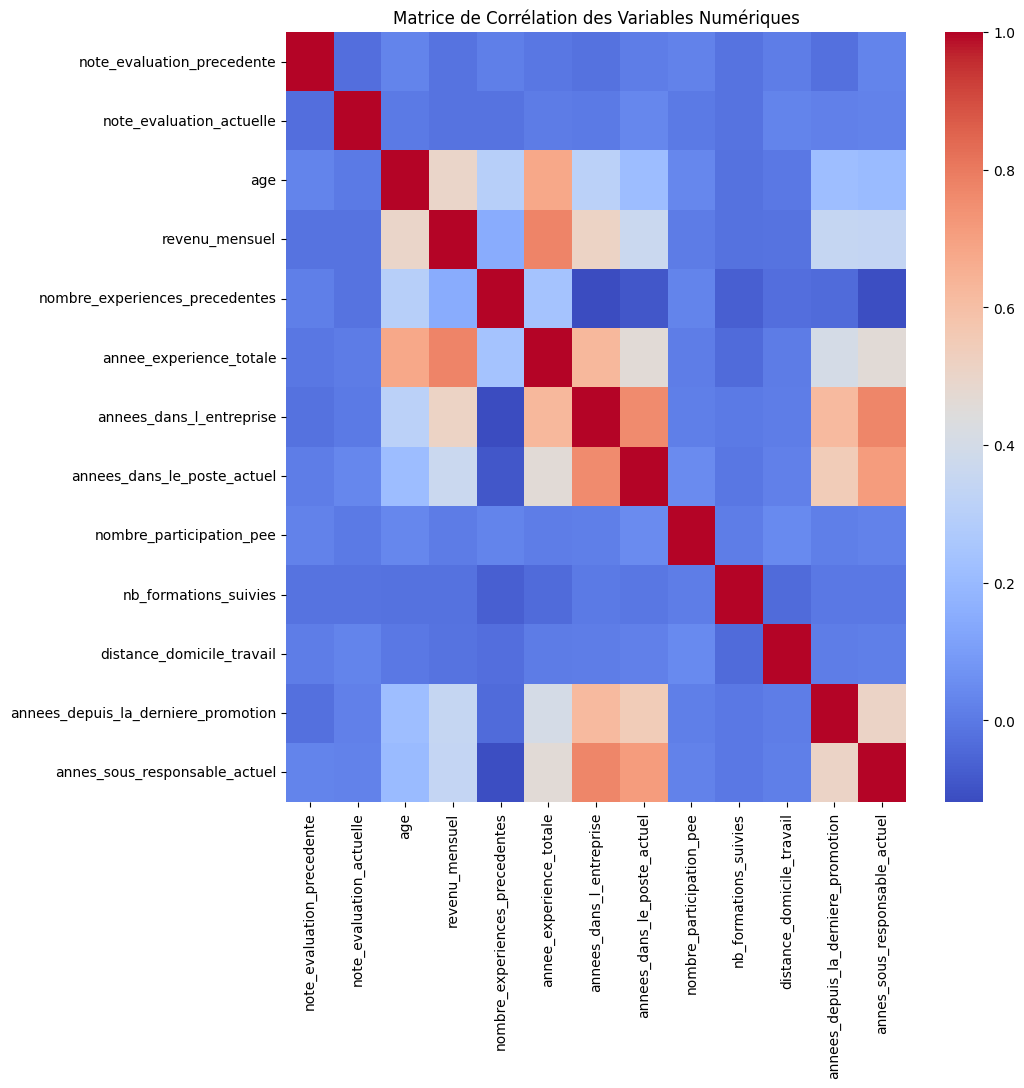

In [709]:
# recherche de correlations 
data_numeric = df_final.select_dtypes(include='number')
corr_matrix = data_numeric.corr()

# plot corr_mat
plt.figure(figsize=[10,10])
sns.heatmap(corr_matrix,annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

In [710]:
# filtrer les variables correlées 
# Définir le seuil de corrélation
THRESHOLD = 0.90
# Créer un ensemble (set) pour stocker les noms de colonnes à supprimer
cols_to_drop = set()

# Parcourir la matrice de corrélation
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # Vérifier si la corrélation est supérieure au seuil
        if corr_matrix.iloc[i, j] > THRESHOLD:
            colname = corr_matrix.columns[i] # Nom de la colonne à l'index 'i'
            cols_to_drop.add(colname)
            
# Supprimer les colonnes identifiées
df_filtered = df_final.drop(columns=cols_to_drop)

# Afficher les résultats
print("-" * 50)
print(f"Seuil de corrélation utilisé : {THRESHOLD}")
print(f"Nombre de variables initiales : {df_final.shape[1]}")
print(f"Nombre de variables supprimées : {len(cols_to_drop)}")
print(f"Variables supprimées : {list(cols_to_drop)}")
print(f"Nombre de variables restantes : {df_filtered.shape[1]}")
print("-" * 50)

--------------------------------------------------
Seuil de corrélation utilisé : 0.9
Nombre de variables initiales : 28
Nombre de variables supprimées : 0
Variables supprimées : []
Nombre de variables restantes : 28
--------------------------------------------------


Il n' y a pas de variables corrélées au seuil de correlation de : 0.9 

Sauvegarde transitoire de df_final

## Transformation des variables catégorielles 

In [711]:
df_final.describe(include = 'category').T

,count,unique,top,freq
satisfaction_employee_environnement,1470,4,3,453
niveau_hierarchique_poste,1470,5,1,543
satisfaction_employee_nature_travail,1470,4,4,459
satisfaction_employee_equipe,1470,4,3,459
satisfaction_employee_equilibre_pro_perso,1470,4,3,893
heure_supplementaires,1470,2,Non,1054
augementation_salaire_precedente,1470,15,11 %,210
genre,1470,2,M,882
statut_marital,1470,3,Marié(e),673
departement,1470,3,Consulting,961


In [712]:
# changer le type de la variable "augementation_salaire_precedente" en numérique et renommer la variable en "augmentation_salaire_precedente_pourc"
df_final['augementation_salaire_precedente'] = [int(x.split(' ')[0]) for x in df_final['augementation_salaire_precedente']]
df_final.rename(columns = {"augementation_salaire_precedente":"augmentation_salaire_precedente_pourc"},inplace=True)

In [713]:
# aperçu variables numériques 
df_final.describe(include ="number").T

,count,mean,std,min,25%,50%,75%,max
note_evaluation_precedente,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.0,4.0
note_evaluation_actuelle,1470.0,3.153741,0.360824,3.0,3.0,3.0,3.0,4.0
augmentation_salaire_precedente_pourc,1470.0,15.209524,3.659938,11.0,12.0,14.0,18.0,25.0
age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.0,60.0
revenu_mensuel,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
nombre_experiences_precedentes,1470.0,2.693197,2.498009,0.0,1.0,2.0,4.0,9.0
annee_experience_totale,1470.0,11.279592,7.780782,0.0,6.0,10.0,15.0,40.0
annees_dans_l_entreprise,1470.0,7.008163,6.126525,0.0,3.0,5.0,9.0,40.0
annees_dans_le_poste_actuel,1470.0,4.229252,3.623137,0.0,2.0,3.0,7.0,18.0
nombre_participation_pee,1470.0,0.793878,0.852077,0.0,0.0,1.0,1.0,3.0


In [714]:
# sauvegarder df_final en CSV (même dossier que les autres jeux de données)
output_path = '../Datasets/dataset_final.csv'
df_final.to_csv(output_path, index=False)
print(f"Fichier sauvegardé : {output_path} aux dimensions {df_final.shape} ")

Fichier sauvegardé : ../Datasets/dataset_final.csv aux dimensions (1470, 28) 


In [715]:
## construire un pîpeline pour normaliser les variables numériques et encoder les variables catégorielles en 